**Name** - Bhaskar Boruah

**Email** - boruah.bhaskar@gmail.com

##Project Title -  Understanding Ego Graph for Structural Profiling through Clustering

#Introduction
The objective of this project is to use machine learning techniques to explore
the complex world of graph analysis, with a focus on clustering based on the local properties of nodes.The primary goal is to analyze and cluster ego graphs obtained from a social network dataset.Ego graphs represent the neighborhood of individual users within a larger social network. The goal was to identify and group similar ego graphs based on their structural properties, hence uncovering cohorts of individuals with similar characteristics or interests.This project has great potential in a variety of domains, including targeted  marketing campaigns, community detection initiatives, and a deeper comprehension of complex social dynamics.

This report summarizes the problem, our approach, experiments conducted, and conclusions drawn.

#Data
#Dataset Description

This dataset consists of 'circles' (or 'friends lists') from Facebook. Facebook data was collected from survey participants using this Facebook app.

* We utilized the "Facebook Combined" dataset from the Stanford SNAP repository.  Link - https://snap.stanford.edu/data/ego-Facebook.html

* The dataset contains ego graphs of Facebook users, representing their friends and connections.

* Each ego graph is represented as an adjacency list.

* Facebook data has been anonymized by replacing the Facebook-internal ids for each user with a new value. Also, while feature vectors from this dataset have been provided, the interpretation of those features has been obscured.

In [ ]:
# Installing dependency
!pip install networkx # Installing NetworkX library
!pip install pycaret --upgrade # Installing Pycaret

In [2]:
# Loading the dependencies
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from pycaret.clustering import *
import itertools
from itertools import combinations  # Import the 'combinations' function
from sklearn.decomposition import PCA
from scipy import stats

In [3]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

#EDA and Data Preprocessing
* Load the dataset
* Perform Exploratory Data Analyis on the loaded data
* Handle missing data by removing nodes with incomplete information.
* Remove isolated nodes as they did not provide meaningful information for clustering.
* Convert it into a ego graph for each node for analysis using NetworkX.

Number of nodes: 4039
Number of edges: 88234


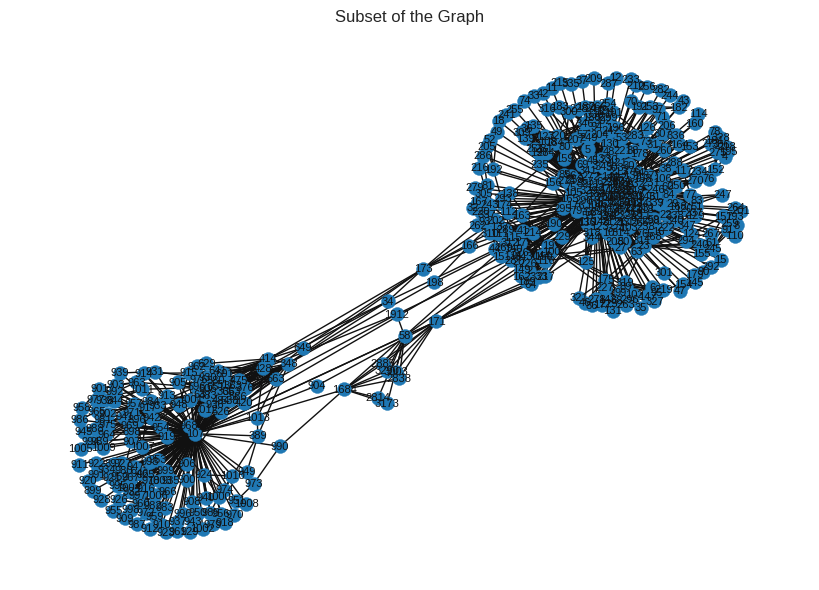

In [4]:
# Define the path to the dataset
#dataset_path = '/content/facebook_combined.txt'

# Load or create your social engineering graph (replace G with your data)
G = nx.Graph()

with open('/content/facebook_combined.txt','r') as file:
  for line in file:
    line = line.strip()      # Remove leading/trailing whitespace and new line characters
    line = line.split(' ')   #split the line up into a list - the first entry will be the node, the others his friends

    if len(line)==1:         #in case the node has no friends, we should still add him to the network
       if line[0] not in G:
                nx.add_node(int(line[0]))
    else:                 #in case the node has friends, loop over all the entries in the list
        focal_node = int(line[0])  #pick your node
        for friend in line[1:]:     #loop over the friends
            G.add_edge(focal_node,int(friend))                 #add each edge to the graph


# Load the dataset into a NetworkX graph
#G = nx.read_edgelist(dataset_path)

# Basic data exploration
print(f"Number of nodes: {len(G.nodes)}")
print(f"Number of edges: {len(G.edges)}")

# Visualize a subset of the graph (e.g., first 500 nodes)
subset_nodes = list(G.nodes)[:500]

# Create a subgraph containing only the subset of nodes and their edges
subset_graph = G.subgraph(subset_nodes)

# Visualize the subset of the graph
pos = nx.spring_layout(subset_graph, seed=42)  # Layout for visualization
nx.draw(subset_graph, pos, with_labels=True, node_size=100, font_size=8)
plt.title('Subset of the Graph')
plt.show()



# Preprocessing:

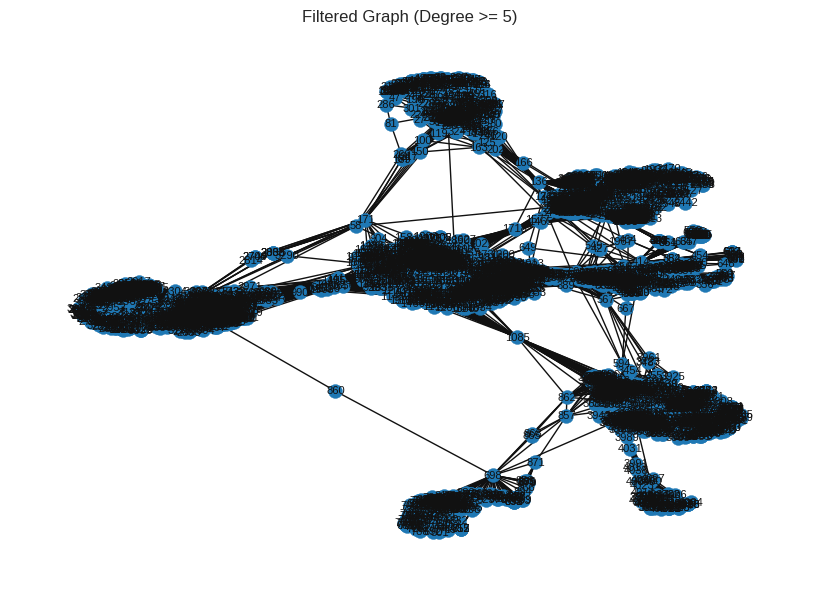

In [6]:


# 1. Removing isolated nodes (nodes with degree 0)
isolated_nodes = [node for node in G.nodes if G.degree(node) == 0]
G.remove_nodes_from(isolated_nodes)

# 2. Handling missing data
# Identify nodes with missing edges by checking if their neighbor list is empty.
# Remove nodes with missing edges using G.remove_nodes_from(missing_nodes).

missing_nodes = [node for node in G.nodes if len(list(G.neighbors(node))) == 0]
G.remove_nodes_from(missing_nodes)


In [10]:
print(f"Number of nodes: {len(G.nodes)}")
print(f"Number of edges: {len(G.edges)}")


Number of nodes: 4039
Number of edges: 88234


**Outlier Removal**

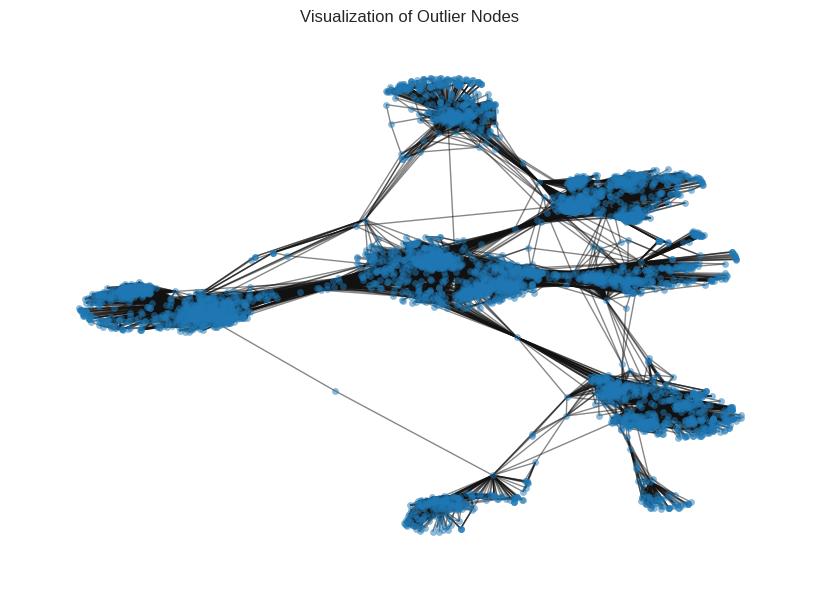

In [7]:

# Calculate Z-scores for the graph data
z_scores = np.abs(stats.zscore(G))

# Define a threshold for identifying outliers (e.g., nodes with Z-scores > 3)
threshold = 3

# Identify outlier nodes based on Z-scores
outliers = [node for node, z_score in enumerate(z_scores) if np.any(z_score > threshold)]

# Create a scatter plot to visualize the outlier nodes
pos = nx.spring_layout(G, seed=42)  # Layout for visualization

# Draw the entire graph
nx.draw(G, pos, with_labels=False, node_size=20, alpha=0.5)

# Highlight outlier nodes with a different color
nx.draw(G.subgraph(outliers), pos, with_labels=False, node_size=50, node_color='red')

plt.title('Visualization of Outlier Nodes')
plt.show()

# Remove outlier nodes and their edges from the original graph
filtered_G = G.copy()
filtered_G.remove_nodes_from(outliers)

# Now, 'filtered_G' contains the original graph with outlier nodes removed


In [8]:
print(f"Number of nodes: {len(filtered_G.nodes)}")
print(f"Number of edges: {len(filtered_G.edges)}")


Number of nodes: 4039
Number of edges: 88234


# Create Ego Graph for all nodes

Definations

"**Ego**" is an individual "focal" node.  A network has as many egos as it has nodes.  Egos can be persons, groups, organizations, or whole societies.

"**Neighborhood**" is the collection of ego and all nodes to whom ego has a connection at some path length.  In social network analysis, the "neighborhood" is almost always one-step; that is, it includes only ego and actors that are directly adjacent.  The neighborhood also includes all of the ties among all of the actors to whom ego has a direct connection.  The boundaries of ego networks are defined in terms of neighborhoods.


In [11]:
# Create an empty dictionary to store ego networks
ego_networks = {}

# Iterate through each node in the graph
for node in filtered_G.nodes():
    # Create the ego network for the current node with 1-hop neighbors
    ego_network = nx.ego_graph(filtered_G, node)

    # Store the ego network in the dictionary with the node as the key
    ego_networks[node] = ego_network




Ego Network for Node 0:
Nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215

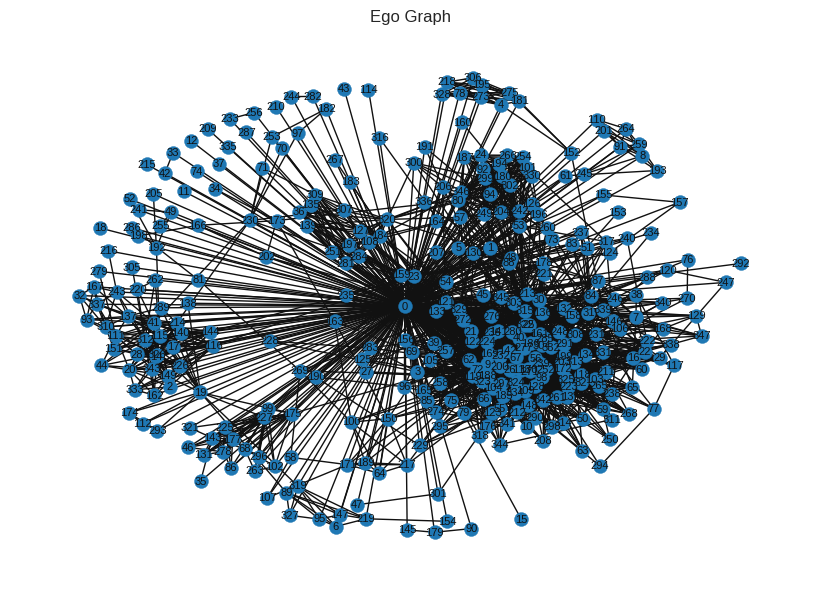

Ego Network for Node 1:
Nodes: [0, 1, 194, 280, 322, 133, 73, 299, 236, 48, 53, 54, 119, 88, 346, 315, 92, 126]
Edges: [(0, 1), (0, 48), (0, 53), (0, 54), (0, 73), (0, 88), (0, 92), (0, 119), (0, 126), (0, 133), (0, 194), (0, 236), (0, 280), (0, 299), (0, 315), (0, 322), (0, 346), (1, 48), (1, 53), (1, 54), (1, 73), (1, 88), (1, 92), (1, 119), (1, 126), (1, 133), (1, 194), (1, 236), (1, 280), (1, 299), (1, 315), (1, 322), (1, 346), (194, 53), (194, 92), (194, 299), (194, 346), (280, 119), (280, 133), (280, 236), (280, 315), (280, 322), (322, 48), (322, 53), (322, 88), (322, 126), (322, 133), (322, 236), (322, 315), (133, 236), (133, 315), (73, 48), (73, 88), (73, 126), (73, 299), (299, 48), (299, 53), (299, 92), (299, 346), (236, 88), (236, 315), (48, 53), (48, 54), (48, 88), (48, 119), (48, 126), (53, 54), (53, 88), (53, 92), (53, 315), (53, 346), (54, 119), (88, 126), (346, 92)]



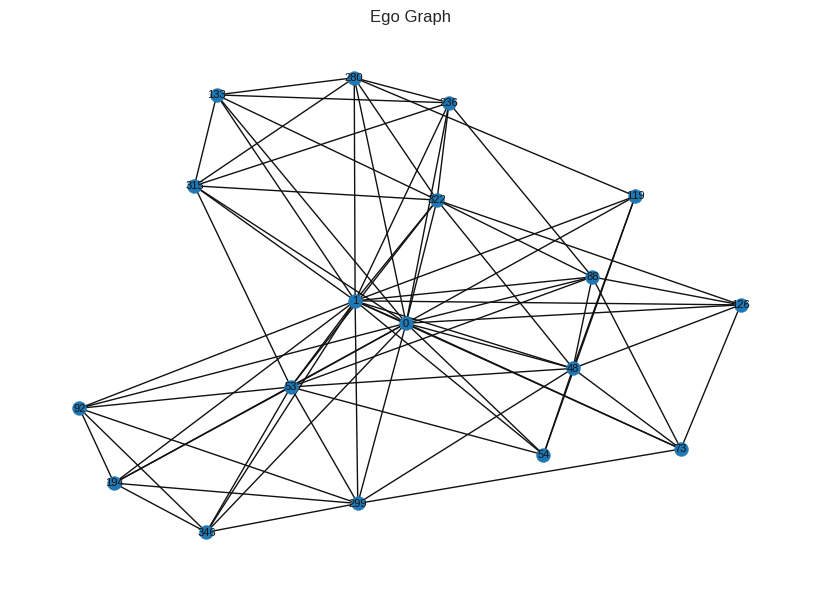

In [12]:
# Basic data exploration of ego_graph
for node in range(2):
    print(f"Ego Network for Node {node}:")
    print("Nodes:", ego_networks[node].nodes())
    print("Edges:", ego_networks[node].edges())
    print()

    # Visualization of ego graph
    pos = nx.spring_layout(ego_networks[node], seed=42)  # Layout for visualization
    nx.draw(ego_networks[node], pos, with_labels=True, node_size=100, font_size=8)
    plt.title(f'Ego Graph')
    plt.show()

## Feature Engineering

Define and extract local node features such as degree, centrality measures, clustering coefficients etc from the ego graph
Create a feature matrix that includes these features for each node.
Normalize or scale the feature matrix if required.

**Feature Defination -**

**Degree:**  The number of edges connected to the node, indicating its local connectivity.

**Centrality Measures:**

* **Betweenness Centrality:** Measures the extent to which a node lies on the shortest paths between other nodes in the ego graph.

* **Closeness Centrality:** Measures how close a node is to all other nodes in the ego graph in terms of geodesic distance.

**Local Clustering Coefficient:** The clustering coefficient of the node itself.Local Clustering Coefficient of a node in a Graph is the fraction of pairs of the node’s neighbours that are adjacent to each other.

**Eigenvector Centrality:** Measures a node's importance based on its connections to other highly central nodes in the ego graph.

**Average Neighbor Degree:** The average degree of a node's neighbors.

**ego_sizes** Size of ego network is the number of nodes that one-step out neighbors of ego, plus ego itself.

**num_directed_ties**  Number of directed ties is the number of connections among all the nodes in the ego network.

**num_ordered_pairs**  Number of ordered pairs is the number of possible directed ties in each ego network.

**densities** Density is the number of ties divided by the number of pairs.  That is, what percentage of all possible ties in each ego network are actually present?

**avg_geodesic_distances** Average geodesic distance is the mean of the shortest path lengths among all connected pairs in the ego network.

**diameters** Diameter of an ego network is the length of the longest path between connected actors (just as it is for any network).

**pairs_not_directly_connecteds** Brokerage (number of pairs not directly connected).  The idea of brokerage (more on this, below) is that ego is the "go-between" for pairs of other actors.  In an ego network, ego is connected to every other actor (by definition).  If these others are not connected directly to one another, ego may be a "broker" ego falls on a the paths between the others.  One item of interest is simply how much potential for brokerage there is for each actor (how many times pairs of neighbors in ego's network are not directly connected).

**normalized_brokerages** Normalized brokerage (brokerage divided by number of pairs) assesses the extent to which ego's role is that of broker.

**ego_betweennesses** Betweenness is an aspect of the larger concept of "centrality."

**normalized_ego_betweennesses** Normalized Betweenness compares the actual betweenness of ego to the maximum possible betweenness in neighborhood of the size and connectivity of ego's.  The "maximum" value for betweenness would be achieved where ego is the center of a "star" network; that is, no neighbors communicate directly with one another, and all directed communications between pairs of neighbors go through ego.



**dyadic_redundancies**  The dyadic redundancy measure calculates, for each actor in ego's neighborhood, how many of the other actors in the neighborhood are also tied to the other.


In [56]:
# Create empty lists to store features
nodes = []
degrees = []
betweenness_centralities = []
closeness_centralities = []
eigenvector_centralities = []
avg_neighbor_degrees = []
ego_sizes = []
num_directed_ties = []
num_ordered_pairs = []
densities = []
avg_geodesic_distances = []
diameters = []
pairs_not_directly_connecteds = []
normalized_brokerages = []
ego_betweennesses = []
normalized_ego_betweennesses = []
clustering_coefficients = []
dyadic_redundancies = []

# Iterate through the dictionary of nodes and ego graphs
for node, ego_graph in ego_networks.items():
    # Calculate the specified features for each node and append to the respective lists
    nodes.append(node)
    degrees.append(ego_graph.degree(node))
    betweenness_centralities.append(nx.betweenness_centrality(ego_graph)[node])
    closeness_centralities.append(nx.closeness_centrality(ego_graph)[node])
    eigenvector_centralities.append(nx.eigenvector_centrality(ego_graph)[node])
    avg_neighbor_degrees.append(nx.average_neighbor_degree(ego_graph)[node])
    ego_sizes.append(len(ego_graph))
    num_directed_ties.append(len(list(ego_graph.neighbors(node))))
    num_ordered_pairs.append(len(list(ego_graph.edges(node))))
    densities.append(nx.density(ego_graph))
    avg_geodesic_distances.append(nx.average_shortest_path_length(ego_graph))
    diameters.append(nx.diameter(ego_graph))


    # Calculate brokerage (number of pairs not directly connected)
    pairs_not_directly_connected = 0
    for node1 in ego_graph.nodes():
        for node2 in ego_graph.nodes():
            if node1 != node2 and not ego_graph.has_edge(node1, node2):
                pairs_not_directly_connected += 1
    pairs_not_directly_connecteds.append(pairs_not_directly_connected)

    # Calculate normalized brokerage
    num_possible_pairs = (len(ego_graph) * (len(ego_graph) - 1)) / 2
    normalized_brokerage = pairs_not_directly_connected / num_possible_pairs
    normalized_brokerages.append(normalized_brokerage)

    # Calculate ego betweenness
    ego_betweenness = nx.betweenness_centrality(ego_graph)[node]
    ego_betweennesses.append(ego_betweenness)

    # Calculate normalized ego betweenness
    normalized_ego_betweenness = ego_betweenness / (len(ego_graph) - 1)
    normalized_ego_betweennesses.append(normalized_ego_betweenness)

    # Calculate clustering coefficient
    clustering_coefficient = nx.clustering(ego_graph, node)
    clustering_coefficients.append(clustering_coefficient)

    # Calculate dyadic redundancy
    dyadic_redundancy = nx.density(nx.ego_graph(ego_graph, node))
    dyadic_redundancies.append(dyadic_redundancy)

# Create a DataFrame from the lists of features
features_df = pd.DataFrame({
    'Node': nodes,
    'Degree': degrees,
    'Betweenness Centrality': betweenness_centralities,
    'Closeness Centrality': closeness_centralities,
    'Eigenvector Centrality': eigenvector_centralities,
    'Average Neighbor Degree': avg_neighbor_degrees,
    'Ego Size': ego_sizes,
    'Number of Directed Ties': num_directed_ties,
    'Number of Ordered Pairs': num_ordered_pairs,
    'Density': densities,
    'Average Geodesic Distance': avg_geodesic_distances,
    'Diameter': diameters,
    'Pairs Not Directly Connected': pairs_not_directly_connecteds,
    'Normalized Brokerage': normalized_brokerages,
    'Ego Betweenness': ego_betweennesses,
    'Normalized Ego Betweenness': normalized_ego_betweennesses,
    'Clustering Coefficient': clustering_coefficients,
    'Dyadic Redundancy': dyadic_redundancies
})


In [57]:
features_df.shape

(4039, 18)

In [58]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4039 entries, 0 to 4038
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Node                          4039 non-null   int64  
 1   Degree                        4039 non-null   int64  
 2   Betweenness Centrality        4039 non-null   float64
 3   Closeness Centrality          4039 non-null   float64
 4   Eigenvector Centrality        4039 non-null   float64
 5   Average Neighbor Degree       4039 non-null   float64
 6   Ego Size                      4039 non-null   int64  
 7   Number of Directed Ties       4039 non-null   int64  
 8   Number of Ordered Pairs       4039 non-null   int64  
 9   Density                       4039 non-null   float64
 10  Average Geodesic Distance     4039 non-null   float64
 11  Diameter                      4039 non-null   int64  
 12  Pairs Not Directly Connected  4039 non-null   int64  
 13  Nor

In [59]:
features_df

,Node,Degree,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality,Average Neighbor Degree,Ego Size,Number of Directed Ties,Number of Ordered Pairs,Density,Average Geodesic Distance,Diameter,Pairs Not Directly Connected,Normalized Brokerage,Ego Betweenness,Normalized Ego Betweenness,Clustering Coefficient,Dyadic Redundancy
0,0,347,0.823842,1.0,0.289796,15.518732,348,347,347,0.047468,1.952532,2,115024,1.905065,0.823842,0.002374,0.041962,0.047468
1,1,17,0.204902,1.0,0.392721,7.705882,18,17,17,0.483660,1.516340,2,158,1.032680,0.204902,0.012053,0.419118,0.483660
2,2,10,0.018333,1.0,0.322646,9.000000,11,10,10,0.909091,1.090909,2,10,0.181818,0.018333,0.001833,0.888889,0.909091
3,3,17,0.113320,1.0,0.294592,11.117647,18,17,17,0.673203,1.326797,2,100,0.653595,0.113320,0.006666,0.632353,0.673203
4,4,10,0.033333,1.0,0.321293,8.800000,11,10,10,0.890909,1.109091,2,12,0.218182,0.033333,0.003333,0.866667,0.890909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,2,0.000000,1.0,0.577350,2.000000,3,2,2,1.000000,1.000000,1,0,0.000000,0.000000,0.000000,1.000000,1.000000
4035,4035,1,0.000000,1.0,0.707107,1.000000,2,1,1,1.000000,1.000000,1,0,0.000000,0.000000,0.000000,0.000000,1.000000
4036,4036,2,0.000000,1.0,0.577350,2.000000,3,2,2,1.000000,1.000000,1,0,0.000000,0.000000,0.000000,1.000000,1.000000
4037,4037,4,0.166667,1.0,0.510036,3.000000,5,4,4,0.800000,1.200000,2,4,0.400000,0.166667,0.041667,0.666667,0.800000


In [60]:
features_df['Closeness Centrality'].unique()

array([1.])

In [61]:
features_df['Diameter'].unique()

array([2, 1])

In [62]:
# Removing "Closeness Centrality" feature as it has only one unique value
features_df.drop('Closeness Centrality', axis=1, inplace=True)

**Feature Removal using Correlation Matrix**

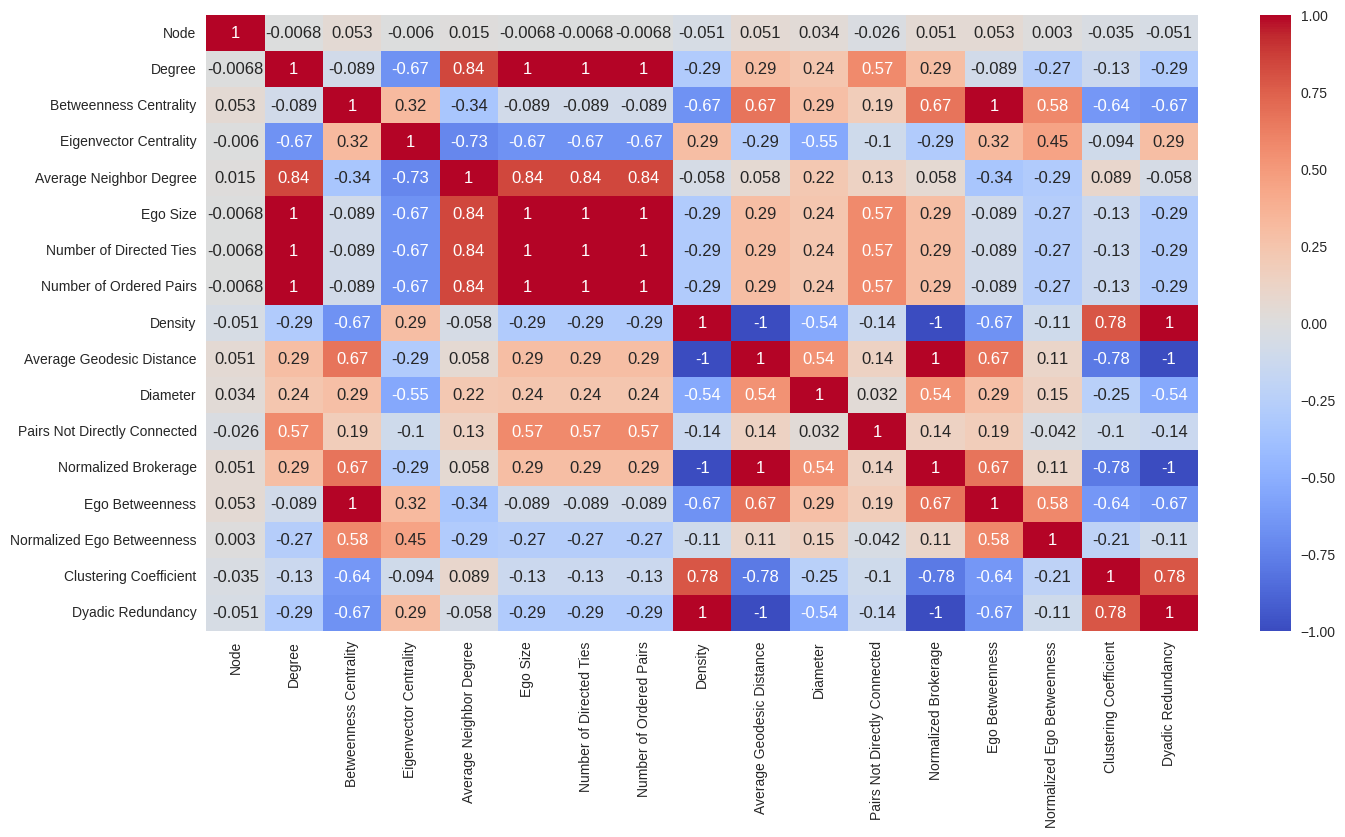

In [63]:
# Assuming 'features_df' is your feature data in a DataFrame
correlation_matrix = features_df.corr()

plt.figure(figsize=(16, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


In [64]:
# Identify Highly Correlated Features
threshold = 0.7
highly_correlated_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            pair = (correlation_matrix.columns[i], correlation_matrix.columns[j])
            highly_correlated_pairs.append(pair)

print("Highly Correlated Feature Pairs:")
print(highly_correlated_pairs)


Highly Correlated Feature Pairs:
[('Average Neighbor Degree', 'Degree'), ('Average Neighbor Degree', 'Eigenvector Centrality'), ('Ego Size', 'Degree'), ('Ego Size', 'Average Neighbor Degree'), ('Number of Directed Ties', 'Degree'), ('Number of Directed Ties', 'Average Neighbor Degree'), ('Number of Directed Ties', 'Ego Size'), ('Number of Ordered Pairs', 'Degree'), ('Number of Ordered Pairs', 'Average Neighbor Degree'), ('Number of Ordered Pairs', 'Ego Size'), ('Number of Ordered Pairs', 'Number of Directed Ties'), ('Average Geodesic Distance', 'Density'), ('Normalized Brokerage', 'Density'), ('Normalized Brokerage', 'Average Geodesic Distance'), ('Ego Betweenness', 'Betweenness Centrality'), ('Clustering Coefficient', 'Density'), ('Clustering Coefficient', 'Average Geodesic Distance'), ('Clustering Coefficient', 'Normalized Brokerage'), ('Dyadic Redundancy', 'Density'), ('Dyadic Redundancy', 'Average Geodesic Distance'), ('Dyadic Redundancy', 'Normalized Brokerage'), ('Dyadic Redundan

In [65]:
print(features_df.columns)


Index(['Node', 'Degree', 'Betweenness Centrality', 'Eigenvector Centrality',
       'Average Neighbor Degree', 'Ego Size', 'Number of Directed Ties',
       'Number of Ordered Pairs', 'Density', 'Average Geodesic Distance',
       'Diameter', 'Pairs Not Directly Connected', 'Normalized Brokerage',
       'Ego Betweenness', 'Normalized Ego Betweenness',
       'Clustering Coefficient', 'Dyadic Redundancy'],
      dtype='object')


In [66]:
# Based on heat map analysis and importance of features
highly_correlated_pairs =['Average Geodesic Distance','Number of Directed Ties', 'Density','Dyadic Redundancy', 'Normalized Brokerage','Ego Betweenness']

# Remove one of the features from each highly correlated pair
for feature1 in highly_correlated_pairs:
    features_df.drop(feature1, axis=1, inplace=True)  # Remove feature1

# features_df now contains the remaining non-correlated features

#for feature1, feature2 in highly_correlated_pairs:
    # Decide which feature to keep, e.g., based on importance or domain knowledge
    # Remove one of the features
    #features_df.drop(feature1, axis=1, inplace=True)  # Remove feature1


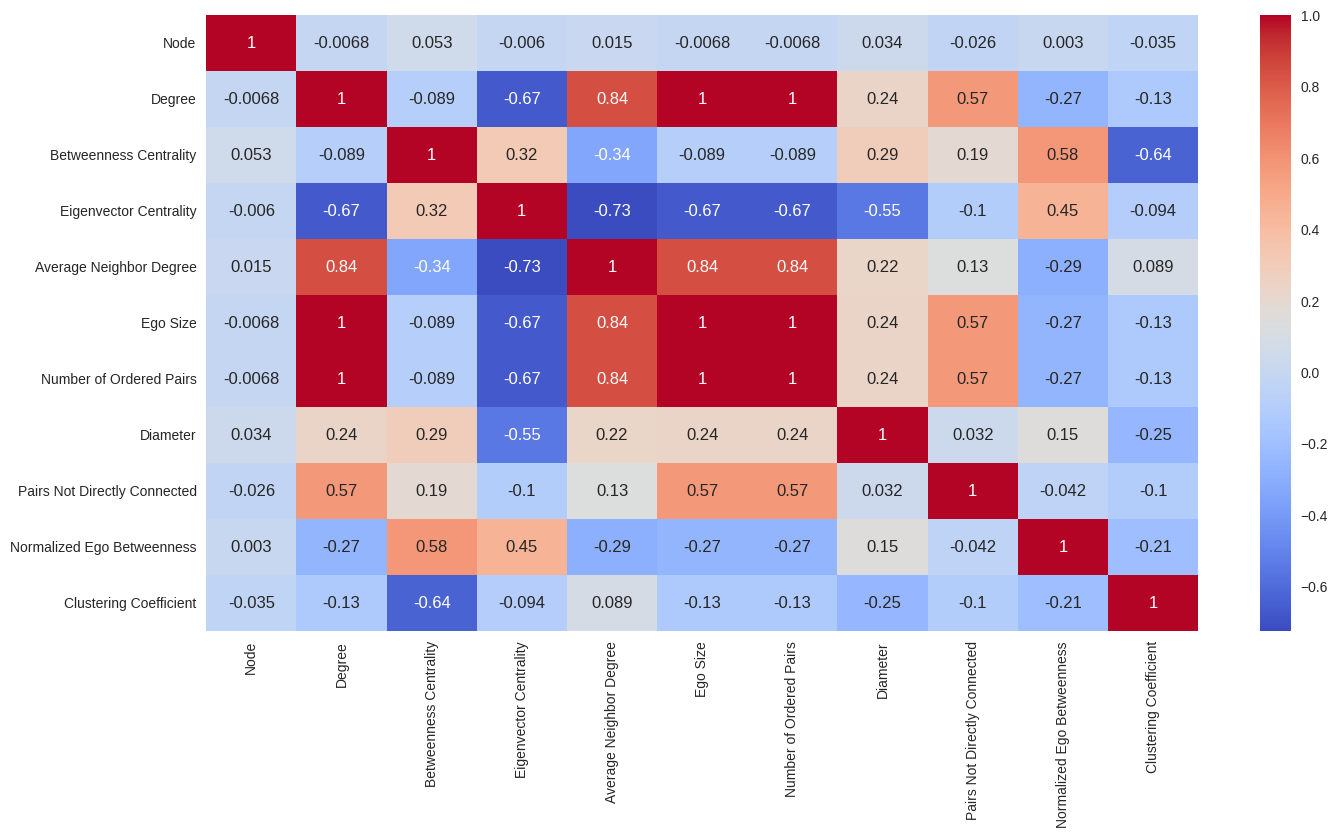

In [67]:
correlation_matrix = features_df.corr()

plt.figure(figsize=(16, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [68]:
features_df.drop('Ego Size', axis=1, inplace=True)

In [69]:
features_df.drop('Number of Ordered Pairs', axis=1, inplace=True)

In [71]:
features_df.drop('Average Neighbor Degree', axis=1, inplace=True)

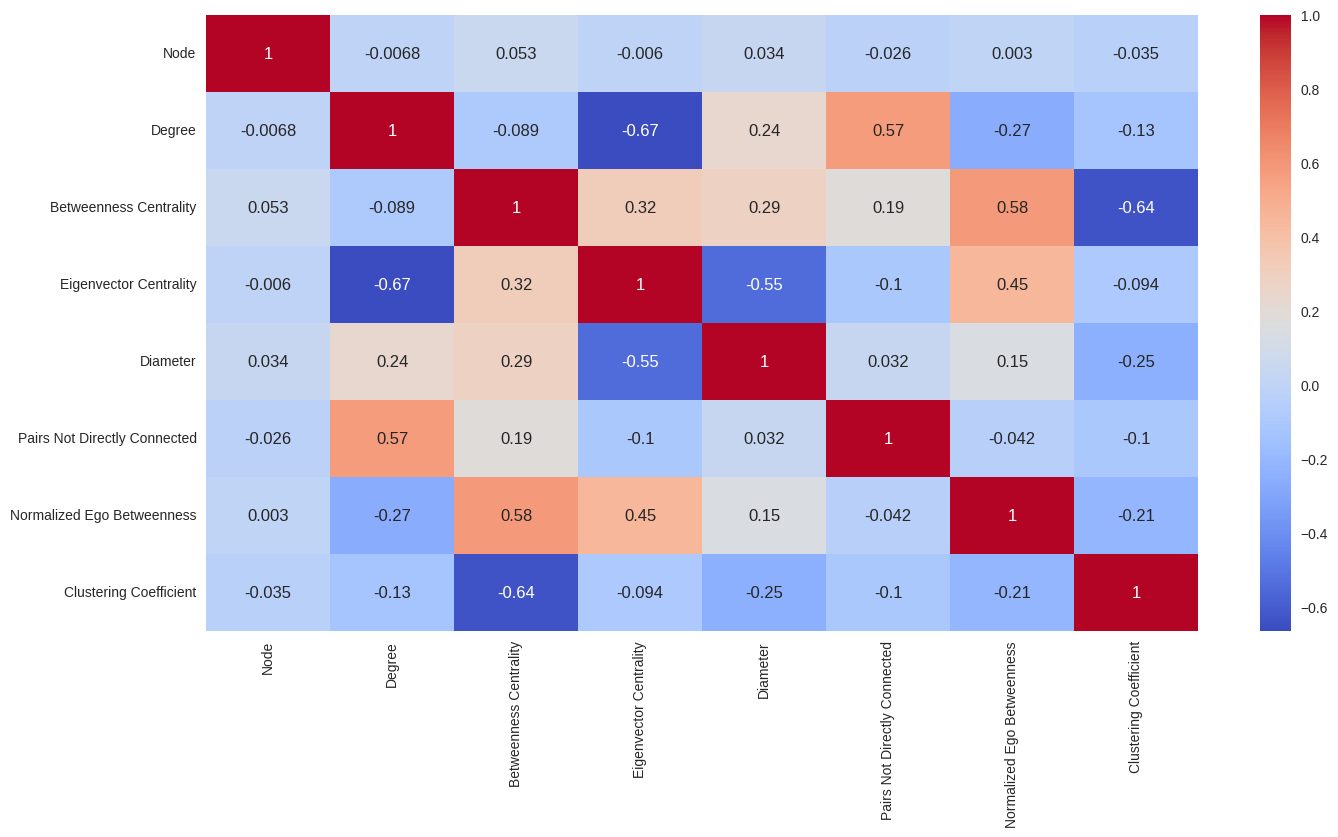

In [72]:
correlation_matrix = features_df.corr()

plt.figure(figsize=(16, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [73]:
features_df.shape

(4039, 8)

## # Perform standardization and normalization

In [74]:
# Perform standardization and normalization
scaler = StandardScaler()
normalized_df = scaler.fit_transform(features_df.drop(columns=['Node']))

minmax_scaler = MinMaxScaler()
normalized_df = minmax_scaler.fit_transform(normalized_df)


## Perform PCA

In [75]:
# Perform PCA
pca = PCA(n_components=0.95)
pca_result = pca.fit_transform(normalized_df)

# Create a DataFrame for PCA results
pca_df = pd.DataFrame(data=pca_result, columns=[f'PCA_{i+1}' for i in range(pca_result.shape[1])])


**Finding the optimal number of clusters is a crucial step in clustering analysis.**

We will use below 2 methods to determine the optimal number of clusters

1. Elbow Method:

The elbow method involves plotting the within-cluster sum of squares (WCSS) against the number of clusters and looking for the "elbow" point where the rate of decrease in WCSS starts to slow down. Use scikit-learn's KMeans and calculate WCSS for different values of k. Then, plot the WCSS values and look for the elbow point.

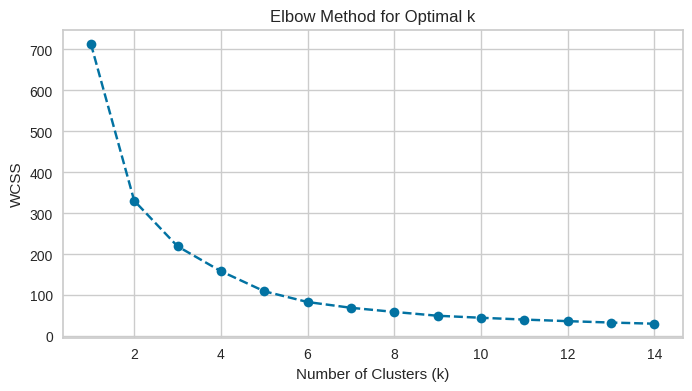

In [76]:
wcss = []
for k in range(1, 15):
    kmeans =  KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(pca_df)
    wcss.append(kmeans.inertia_)

# Plot the WCSS values
plt.figure(figsize=(8, 4))
plt.plot(range(1, 15), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k')
plt.show()

2. Silhouette Score:

The silhouette score measures how similar each data point is to its own cluster compared to other clusters. Higher silhouette scores indicate better cluster separation.
Calculate the silhouette score for different values of k and choose the k that maximizes the silhouette score.

Optimal number of clusters: 2



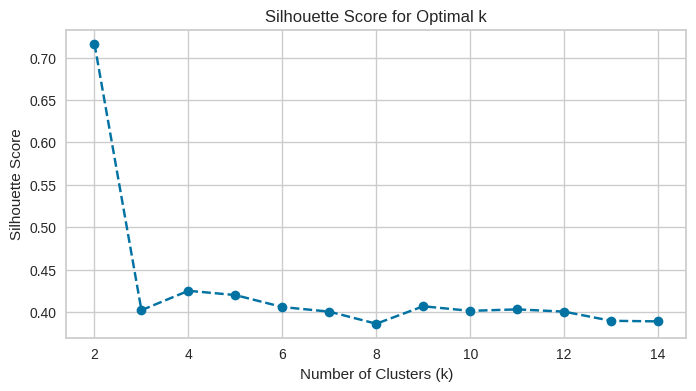

In [77]:
# Calculate Silhouette Score for different k values
silhouette_scores = []
for i in range(2, 15):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(pca_df)
    silhouette_scores.append(silhouette_score(pca_df, kmeans.labels_))

# Find the number of clusters with the highest Silhouette Score
optimal_num_clusters = silhouette_scores.index(max(silhouette_scores)) + 2  # Add 2 due to starting from 2 clusters
print("Optimal number of clusters:", optimal_num_clusters)
print()

# Plot the silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(range(2, 15), silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.show()

##Perform Clustering Analysis

	•	Apply various clustering algorithms (e.g., k-means, hierarchical clustering, DBSCAN) to the feature-engineered data.
	•	Experiment with different parameter settings for each clustering algorithm.
	•	Evaluate the quality of clusters using appropriate metrics.

In [78]:
# Perform k-means clustering with different values of 'k'
k_values = [ 3, 4, 5,8,10]
kmeans_results = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans_labels = kmeans.fit_predict(pca_df)

    # Evaluate k-means clustering using Silhouette Score
    silhouette_avg = silhouette_score(pca_df, kmeans_labels)
    ch_score = calinski_harabasz_score(pca_df, kmeans_labels)
    db_score = davies_bouldin_score(pca_df, kmeans_labels)

    kmeans_results.append({
        'k': k,
        'labels': kmeans_labels,
        'silhouette_score': silhouette_avg,
        'calinski_harabasz_score': ch_score,
        'davies_bouldin_score': db_score
    })

# Perform hierarchical clustering with different linkage methods
linkage_methods = ['ward', 'complete', 'average', 'single']
hierarchical_results = []

for linkage in linkage_methods:
    hierarchical = AgglomerativeClustering(n_clusters=3, linkage=linkage)
    hierarchical_labels = hierarchical.fit_predict(pca_df)

    # Evaluate hierarchical clustering using Silhouette Score
    silhouette_avg = silhouette_score(pca_df, hierarchical_labels)
    ch_score = calinski_harabasz_score(pca_df, hierarchical_labels)
    db_score = davies_bouldin_score(pca_df, hierarchical_labels)

    hierarchical_results.append({
        'linkage': linkage,
        'labels': hierarchical_labels,
        'silhouette_score': silhouette_avg,
        'calinski_harabasz_score': ch_score,
        'davies_bouldin_score': db_score
    })


# Perform DBSCAN clustering with different parameters
eps_values = [0.1, 0.2, 0.3]
min_samples_values = [5, 10, 20]
dbscan_results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(pca_df)

        # Evaluate DBSCAN clustering using Silhouette Score
        if len(np.unique(dbscan_labels)) > 1:
            silhouette_avg = silhouette_score(pca_df, dbscan_labels)
            db_score =  davies_bouldin_score(pca_df, dbscan_labels)
        else:
            silhouette_avg = -1  # DBSCAN may result in a single cluster
            db_score = -1


        dbscan_results.append({
            'eps': eps,
            'min_samples': min_samples,
            'labels': dbscan_labels,
            'silhouette_score': silhouette_avg,
            'davies_bouldin_score': db_score
        })


# Print and analyze the clustering results
print("K-Means Clustering Results:")
kmeans_df = pd.DataFrame(kmeans_results)
print(kmeans_df)

print("\nHierarchical Clustering Results:")
hierarchical_df = pd.DataFrame(hierarchical_results)
print(hierarchical_df)

print("\nDBSCAN Clustering Results:")
dbscan_df = pd.DataFrame(dbscan_results)
print(dbscan_df)


K-Means Clustering Results:
    k                                             labels  silhouette_score  \
0   3  [2, 2, 0, 0, 0, 2, 0, 2, 2, 2, 0, 1, 1, 0, 0, ...          0.402197   
1   4  [0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 2, 3, 3, 2, 2, ...          0.424260   
2   5  [2, 2, 4, 4, 4, 2, 4, 2, 4, 0, 4, 3, 3, 0, 4, ...          0.419997   
3   8  [0, 0, 3, 6, 3, 0, 3, 5, 6, 5, 3, 4, 4, 7, 3, ...          0.387652   
4  10  [8, 8, 4, 0, 4, 8, 4, 6, 5, 6, 4, 2, 2, 0, 7, ...          0.401961   

   calinski_harabasz_score  davies_bouldin_score  
0              4539.921230              0.866599  
1              4694.149920              0.627045  
2              5533.225626              0.615727  
3              6272.916611              0.710755  
4              6591.660442              0.714848  

Hierarchical Clustering Results:
    linkage                                             labels  \
0      ward  [2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 0, 0, 1, 1, ...   
1  complete  [0, 0, 0, 0, 0, 0,

In [79]:
# Define a list of parameter combinations to try
eps_values = [0.1, 0.2, 0.3]  # Adjust these values as needed
min_samples_values = [5, 10, 20]  # Adjust these values as needed

best_dbscan = None
best_labels = None
best_silhouette_score = -1  # Initialize with a low value

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(pca_df)

        # Exclude noise points (-1) from the silhouette score calculation
        if len(np.unique(labels)) > 1:
            silhouette_avg = silhouette_score(pca_df, labels)
        else:
            silhouette_avg = -1

        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_dbscan = dbscan
            best_labels = labels

# Print the best DBSCAN parameters and silhouette score
print("Best DBSCAN Parameters:")
print("Eps:", best_dbscan.eps)
print("Min Samples:", best_dbscan.min_samples)
print("Silhouette Score:", best_silhouette_score)

Best DBSCAN Parameters:
Eps: 0.3
Min Samples: 5
Silhouette Score: 0.7027174022770256


##Evaluate Clustering Performance

Calculate Silhouette Score to evaluate the quality of clusters.

In [80]:
# Calculate Silhouette Score
silhouette_avg = silhouette_score(pca_df, kmeans_labels)

# Print the Silhouette Score
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.4019613708085655


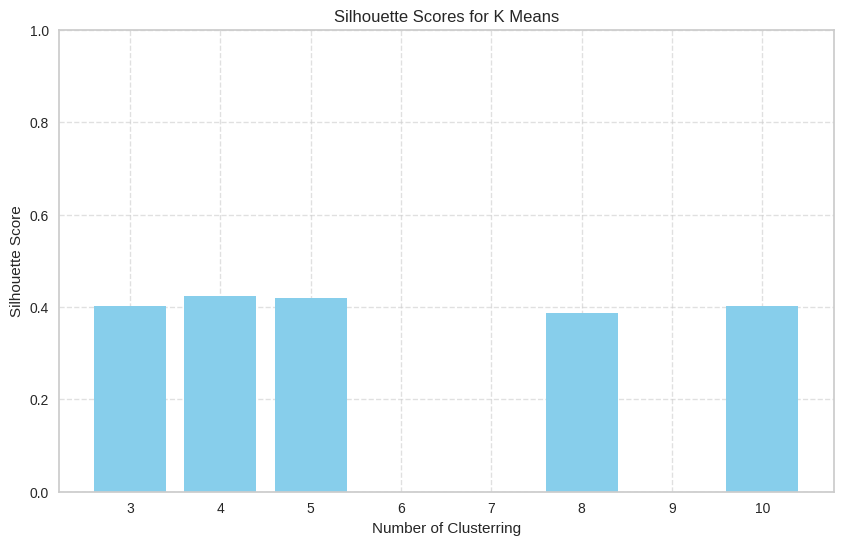

In [81]:
plt.figure(figsize=(10, 6))
plt.bar(kmeans_df['k'], kmeans_df['silhouette_score'], color='skyblue')
plt.xlabel('Number of Clusterring')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for K Means')
plt.ylim(0, 1)  # Set y-axis limits (0 to 1)
plt.grid( linestyle='--', alpha=0.6)
plt.show()


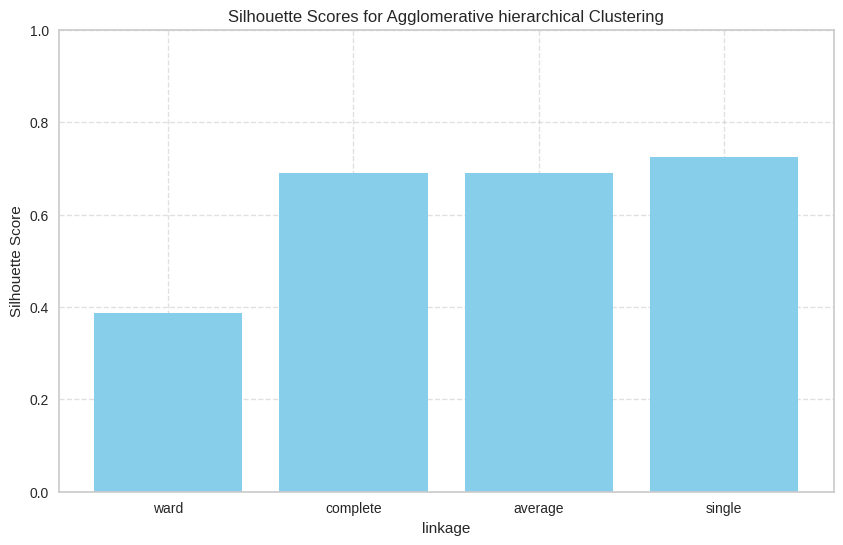

In [82]:
# Create a bar plot for Silhouette Scores for Agglomerative hierarchical Clustering using different linkage
plt.figure(figsize=(10, 6))
plt.bar(hierarchical_df['linkage'], hierarchical_df['silhouette_score'], color='skyblue')
plt.xlabel('linkage')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Agglomerative hierarchical Clustering')
plt.ylim(0, 1)  # Set y-axis limits (0 to 1)
plt.grid( linestyle='--', alpha=0.6)
plt.show()

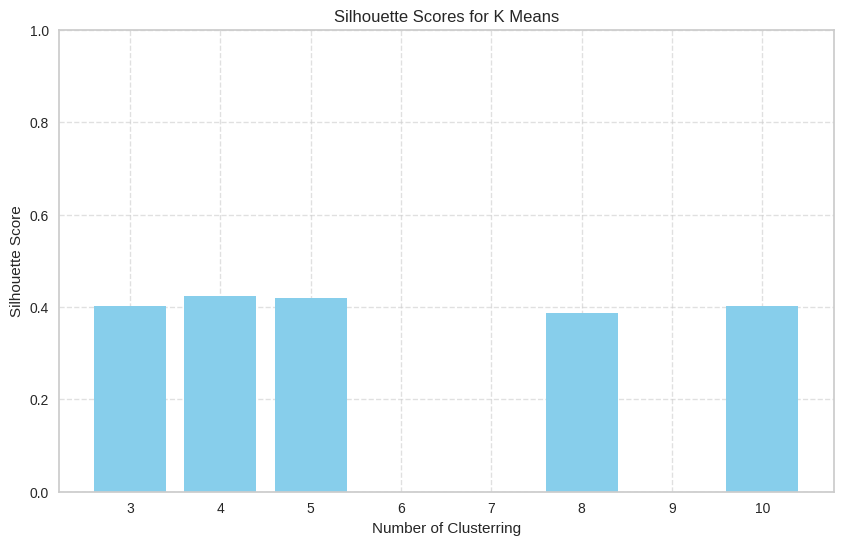

In [83]:
plt.figure(figsize=(10, 6))
plt.bar(kmeans_df['k'], kmeans_df['silhouette_score'], color='skyblue')

plt.xlabel('Number of Clusterring')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for K Means')
plt.ylim(0, 1)  # Set y-axis limits (0 to 1)
plt.grid( linestyle='--', alpha=0.6)
plt.show()

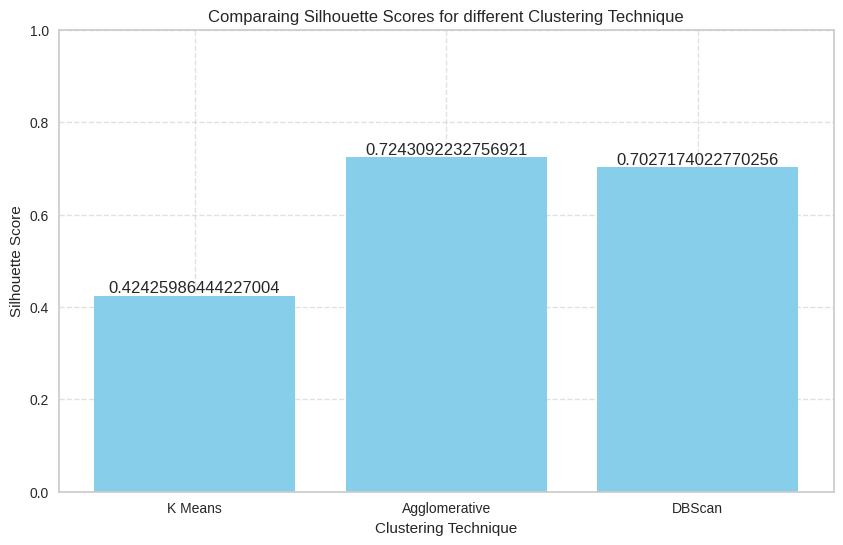

In [84]:
# Plotting silhouette_score against each clustering technique

data = {
    'clustering_technique': ['K Means', 'Agglomerative', 'DBScan'],
    'silhouette_score': [max(kmeans_df['silhouette_score']), max(hierarchical_df['silhouette_score']), max(dbscan_df['silhouette_score'])]
}

# Create the DataFrame
df = pd.DataFrame(data)


plt.figure(figsize=(10, 6))
plt.bar(df['clustering_technique'], df['silhouette_score'], color='skyblue',)
# Add labels to the bars
for i, v in enumerate(df['silhouette_score']):
    plt.annotate(str(v), (i, v), ha='center', va='bottom')

plt.xlabel('Clustering Technique')
plt.ylabel('Silhouette Score')
plt.title('Comparaing Silhouette Scores for different Clustering Technique')
plt.ylim(0, 1)  # Set y-axis limits (0 to 1)
plt.grid( linestyle='--', alpha=0.6,)
plt.show()

In [85]:
# Print and analyze the K Means clustering results

max_silhouette_score_row = kmeans_df[ kmeans_df['silhouette_score'] == kmeans_df['silhouette_score'].max() ]

cluster_no_silhouette_score = max_silhouette_score_row['k'].values[0]
max_silhouette_score = max_silhouette_score_row['silhouette_score'].values[0]
print("K Means clustering results")
print()

print(f"Based on Maximum Silhouette Score: {max_silhouette_score}, Optimal number of clusters (k) : {cluster_no_silhouette_score} ")

max_ch_score_row = kmeans_df[ kmeans_df['calinski_harabasz_score'] == kmeans_df['calinski_harabasz_score'].max() ]

cluster_no_ch_score = max_ch_score_row['k'].values[0]
max_sch_score = max_ch_score_row['calinski_harabasz_score'].values[0]

print(f"Based on Maximum calinski harabasz score: {max_sch_score}, Optimal number of clusters (k) : {cluster_no_ch_score} ")


min_db_score_row = kmeans_df[ kmeans_df['davies_bouldin_score'] == kmeans_df['davies_bouldin_score'].min() ]

cluster_no_db_score = min_db_score_row['k'].values[0]
max_db_score = min_db_score_row['davies_bouldin_score'].values[0]

print(f"Based on Maximum davies bouldin score: {max_db_score}, Optimal number of clusters (k) : {cluster_no_db_score} ")



K Means clustering results

Based on Maximum Silhouette Score: 0.42425986444227004, Optimal number of clusters (k) : 4 
Based on Maximum calinski harabasz score: 6591.660441794133, Optimal number of clusters (k) : 10 
Based on Maximum davies bouldin score: 0.6157272403290853, Optimal number of clusters (k) : 5 


In [87]:
# Print and analyze the Agglomerative hierarchical Clustering  results

max_silhouette_score_row = hierarchical_df[ hierarchical_df['silhouette_score'] == hierarchical_df['silhouette_score'].max() ]

best_linkage = max_silhouette_score_row['linkage'].values[0]
max_silhouette_score = max_silhouette_score_row['silhouette_score'].values[0]

print("Agglomerative hierarchical Clustering results")
print()

print(f"Based on Maximum Silhouette Score: {max_silhouette_score}, Best linkage method : {best_linkage} ")

max_ch_score_row = hierarchical_df[ hierarchical_df['calinski_harabasz_score'] == hierarchical_df['calinski_harabasz_score'].max() ]

best_linkage_ch = max_ch_score_row['linkage'].values[0]
max_sch_score = max_ch_score_row['calinski_harabasz_score'].values[0]

print(f"Based on Maximum calinski harabasz score: {max_sch_score}, Best linkage method : {best_linkage_ch} ")


min_db_score_row = hierarchical_df[ hierarchical_df['davies_bouldin_score'] == hierarchical_df['davies_bouldin_score'].min() ]

best_linkage_db = min_db_score_row['linkage'].values[0]
max_db_score = min_db_score_row['davies_bouldin_score'].values[0]

print(f"Based on Maximum davies bouldin score: {max_db_score}, Best linkage method : {best_linkage_db} ")


Agglomerative hierarchical Clustering results

Based on Maximum Silhouette Score: 0.7243092232756921, Best linkage method : single 
Based on Maximum calinski harabasz score: 4367.1521653584105, Best linkage method : ward 
Based on Maximum davies bouldin score: 0.2660437294743572, Best linkage method : single 


In [88]:
# Print and analyze the DB Scan Clustering  results

max_silhouette_score_row = dbscan_df[ dbscan_df['silhouette_score'] == dbscan_df['silhouette_score'].max() ]

best_eps = max_silhouette_score_row['eps'].values[0]
best_min_samples = max_silhouette_score_row['min_samples'].values[0]
max_silhouette_score = max_silhouette_score_row['silhouette_score'].values[0]

print("DB Scan Clustering results")
print()

print(f"Based on Maximum Silhouette Score: {max_silhouette_score}, Optimal parameters: epsilon = {best_eps}, min_samples = {best_min_samples}  ")

min_db_score_row = dbscan_df[ dbscan_df['davies_bouldin_score'] == dbscan_df['davies_bouldin_score'].min() ]

best_eps_db = min_db_score_row['eps'].values[0]
best_min_samples_db = min_db_score_row['min_samples'].values[0]
min_db_score = min_db_score_row['silhouette_score'].values[0]

print(f"Based on Minimum davies bouldin Score: {min_db_score}, Optimal parameters: epsilon = {best_eps_db}, min_samples = {best_min_samples_db}  ")


DB Scan Clustering results

Based on Maximum Silhouette Score: 0.7027174022770256, Optimal parameters: epsilon = 0.3, min_samples = 5  
Based on Minimum davies bouldin Score: 0.7027174022770256, Optimal parameters: epsilon = 0.3, min_samples = 5  


In [89]:
pca_df.info

<bound method DataFrame.info of          PCA_1     PCA_2     PCA_3
0    -0.266123  0.678498  0.194019
1    -0.042757  0.267334 -0.074745
2     0.015212 -0.229019 -0.204234
3    -0.067590 -0.011802 -0.061474
4     0.008447 -0.207056 -0.194363
...        ...       ...       ...
4034  1.083664 -0.175628 -0.027383
4035  0.973585  0.736624  0.330775
4036  1.083664 -0.175628 -0.027383
4037  0.103814  0.148554 -0.323705
4038  0.007791  0.162999 -0.164085

[4039 rows x 3 columns]>

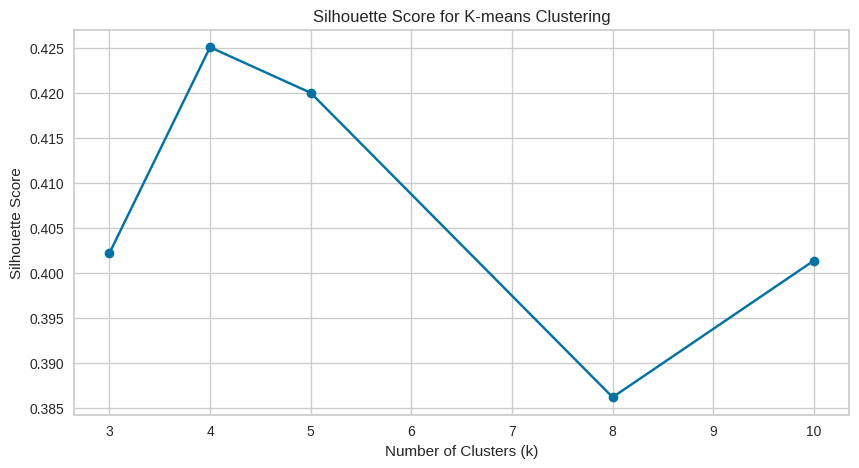

In [90]:
# Extract the features for clustering
X = pca_df[['PCA_1', 'PCA_2', 'PCA_3']]

# Perform K-means clustering with different numbers of clusters (adjust k_values)
k_values = [ 3, 4, 5,8,10]  # You can adjust these values
silhouette_scores_kmeans = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(X)
    silhouette_score_kmeans = silhouette_score(X, labels)
    silhouette_scores_kmeans.append(silhouette_score_kmeans)

# Plot the silhouette scores for K-means
plt.figure(figsize=(10, 5))
plt.plot(k_values, silhouette_scores_kmeans, marker='o', linestyle='-')
plt.title('Silhouette Score for K-means Clustering')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

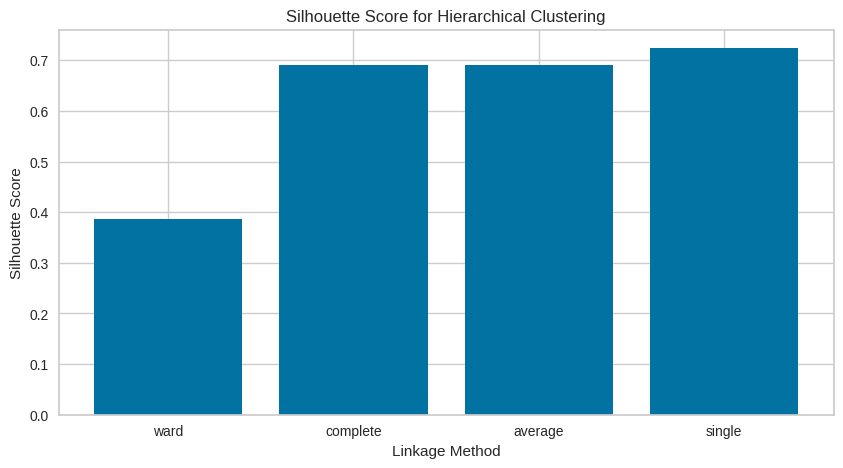

In [91]:
# Perform Hierarchical Clustering with different linkage methods (adjust linkage_methods)
linkage_methods = ['ward', 'complete', 'average', 'single']  # You can adjust these values
silhouette_scores_hierarchy = []

for linkage in linkage_methods:
    hierarchical = AgglomerativeClustering(n_clusters=3, linkage=linkage)
    labels = hierarchical.fit_predict(X)
    silhouette_score_hierarchy = silhouette_score(X, labels)
    silhouette_scores_hierarchy.append(silhouette_score_hierarchy)

# Plot the silhouette scores for Hierarchical Clustering
plt.figure(figsize=(10, 5))
plt.bar(linkage_methods, silhouette_scores_hierarchy)
plt.title('Silhouette Score for Hierarchical Clustering')
plt.xlabel('Linkage Method')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()


#Model Evaluation using Pycaret

In [92]:
# Initialize the PyCaret environment
exp_clu = setup(data=pca_df, normalize=True, session_id=123)


,Description,Value
0,Session id,123
1,Original data shape,"(4039, 3)"
2,Transformed data shape,"(4039, 3)"
3,Numeric features,3
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,Normalize,True
9,Normalize method,zscore


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4042,2724.0800,0.8218,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3670,2193.8115,0.8065,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.5289,817.5703,0.6202,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3974,1744.7083,0.6879,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

<Figure size 800x550 with 0 Axes>

<Figure size 800x550 with 0 Axes>

<Figure size 800x550 with 0 Axes>

<Figure size 800x550 with 0 Axes>

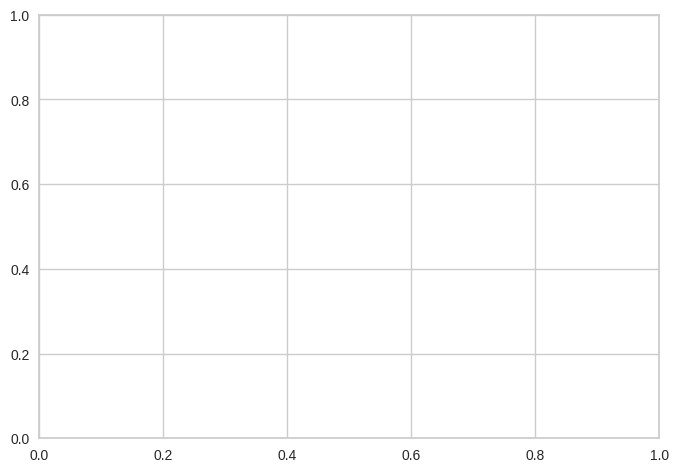

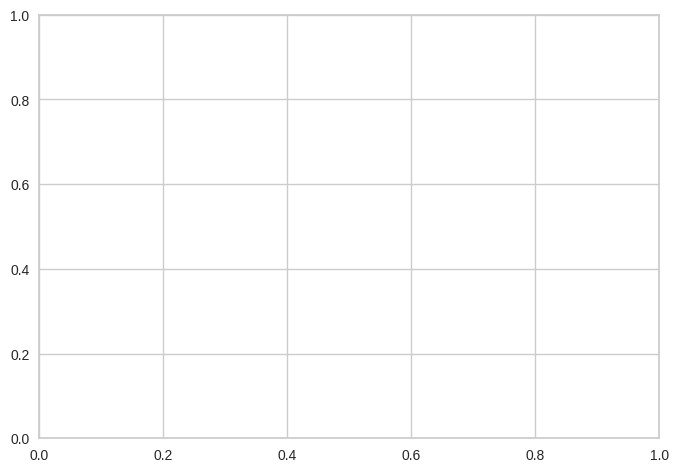

<Figure size 800x550 with 0 Axes>

<Figure size 800x550 with 0 Axes>

In [93]:
# Import necessary functions from pycaret.clustering module
from pycaret.clustering import create_model, evaluate_model

# Create and evaluate KMeans clustering model
kmeans = create_model('kmeans')
evaluate_model(kmeans)

# Create and evaluate Hierarchical clustering model
hierarchical = create_model('hclust')
evaluate_model(hierarchical)

# Create and evaluate DBScan clustering model
dbscan = create_model('dbscan')
evaluate_model(dbscan)

# Create and evaluate BIRCH clustering model
birch = create_model('birch')
evaluate_model(birch)


In [94]:
# Visualize KMeans clusters
plot_model(kmeans, plot='cluster')

# Visualize Hierarchical clusters
plot_model(hierarchical, plot='cluster')

# Visualize DBScan clusters
plot_model(dbscan, plot='cluster')

# Visualize BIRCH clusters
plot_model(birch, plot='cluster')


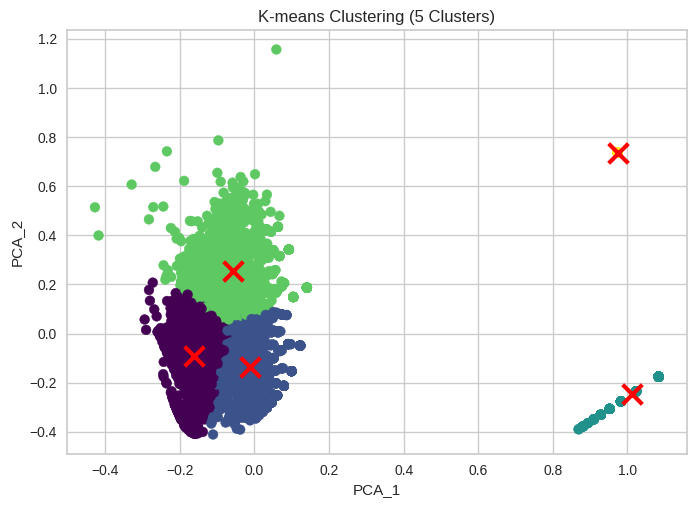

In [95]:

pca_array = pca_df[['PCA_1', 'PCA_2','PCA_3']].to_numpy()

# Fit K-means to the data with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(pca_array)

# Get cluster labels
labels = kmeans.labels_

# Get cluster centers
centers = kmeans.cluster_centers_

# Plot the data points with cluster colors and centroids
plt.scatter(pca_array[:, 0], pca_array[:, 1], c=labels, cmap='viridis', s=50)
plt.scatter(centers[:, 0], centers[:, 1], marker='x', s=200, linewidths=3, color='red')
#The centroids of the clusters are marked with red 'x' symbols.
plt.title('K-means Clustering (5 Clusters)')
plt.xlabel('PCA_1')
plt.ylabel('PCA_2')
plt.show()

#Results and Insights
1. **K-Means Clustering:**

    * Based on Maximum Silhouette Score: 0.42425986444227004, Optimal number of clusters (k) : 4

    * Based on Maximum calinski harabasz score: 6591.660441794133, Optimal number of clusters (k) : 10

    * Based on Maximum davies bouldin score: 0.6157272403290853, Optimal number of clusters (k) : 5




2.  **Agglomerative Hierarchical Clustering:**

    Best linkage method: single

    * Based on Maximum Silhouette Score: 0.7243092232756921,
      Best linkage method : single

    * Based on Maximum calinski harabasz score: 4367.1521653584105, Best linkage method : ward

    * Based on Maximum davies bouldin score: 0.2660437294743572, Best linkage method : single



3. **DBSCAN:**

    Optimal parameters: epsilon = 0.3, min_samples = 5

    * Based on Maximum Silhouette Score: 0.7027174022770256, Optimal parameters: epsilon = 0.3, min_samples = 5  

    *  Based on Minimum davies bouldin Score: 0.7027174022770256,
    Optimal parameters: epsilon = 0.3, min_samples = 5  



#Conclusion

* Clustering analysis of ego graphs provides insights into user behavior and social network structures.

* K-Means, Agglomerative Hierarchical Clustering, and DBSCAN clustering were applied, with Agglomerative Hierarchical Clustering achieving the best results.

* Ego graph clustering can aid in community detection and personalized content recommendation in social networks.


## References

https://faculty.ucr.edu/~hanneman/nettext/C9_Ego_networks.html
